<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_Course_3_Week_2_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import json
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
print(f'Tensorflow version: {tf.__version__}')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Tensorflow version: 2.1.0


In [0]:
vocab_size = 20000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-02-10 16:17:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-02-10 16:17:20 (144 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 16)           320000    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 25        
Total params: 320,433
Trainable params: 320,433
Non-trainable params: 0
_________________________________________________________________


In [46]:
num_epochs = 10
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/10
20000/20000 - 4s - loss: 0.6667 - accuracy: 0.5910 - val_loss: 0.5891 - val_accuracy: 0.7187
Epoch 2/10
20000/20000 - 4s - loss: 0.4342 - accuracy: 0.8339 - val_loss: 0.3955 - val_accuracy: 0.8267
Epoch 3/10
20000/20000 - 4s - loss: 0.3030 - accuracy: 0.8821 - val_loss: 0.3506 - val_accuracy: 0.8548
Epoch 4/10
20000/20000 - 4s - loss: 0.2425 - accuracy: 0.9083 - val_loss: 0.3554 - val_accuracy: 0.8450
Epoch 5/10
20000/20000 - 4s - loss: 0.1994 - accuracy: 0.9261 - val_loss: 0.3380 - val_accuracy: 0.8578
Epoch 6/10
20000/20000 - 4s - loss: 0.1652 - accuracy: 0.9414 - val_loss: 0.3448 - val_accuracy: 0.8581
Epoch 7/10
20000/20000 - 4s - loss: 0.1378 - accuracy: 0.9524 - val_loss: 0.3576 - val_accuracy: 0.8569
Epoch 8/10
20000/20000 - 4s - loss: 0.1161 - accuracy: 0.9617 - val_loss: 0.3743 - val_accuracy: 0.8566
Epoch 9/10
20000/20000 - 4s - loss: 0.0974 - accuracy: 0.9700 - val_loss: 0.3953 - val_accuracy: 0.8542
Epoch 10/10
200

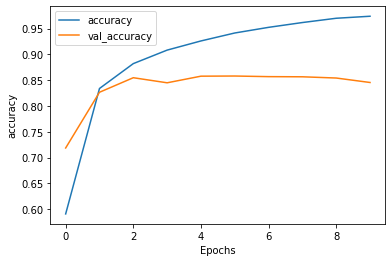

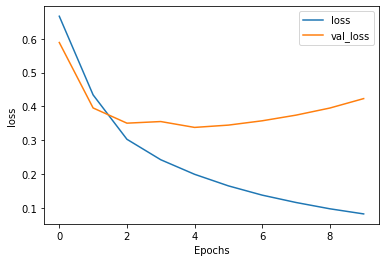

In [47]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))